In [1]:
import pandas as pd
from sklearn.utils import resample
from matplotlib import pyplot as plt
import numpy as np
import itertools
import seaborn as sns; sns.set_style('whitegrid');

In [2]:
df = pd.DataFrame({
    'Player': ['Juju Smith-Schuster', 'Devante Parker', 'Tyler Boyd'],
    'Sleeper': [16.20, 13.92, 14.23],
    'FanDuel': [15.84, 12.20, 11.92],
    'ESPN': [14.60, 12.50, 11.70],
    'FantasyPros': [15.60, 11.70, 12.30],
    'fftoday': [14.60, 13.10, 7.60],
    'ffcalculator': [16.20, 14.0, 14.50],
    'walterfootball': [18.0, 10.0, 10.0]
})

df.head()

,Player,Sleeper,FanDuel,ESPN,FantasyPros,fftoday,ffcalculator,walterfootball
0,Juju Smith-Schuster,16.20,15.84,14.6,15.6,14.6,16.2,18.0
1,Devante Parker,13.92,12.20,12.5,11.7,13.1,14.0,10.0
2,Tyler Boyd,14.23,11.92,11.7,12.3,7.6,14.5,10.0


In [3]:
# grabbing each player's weekly fantasy points as an array
juju = df.iloc[0, 1:].to_numpy()
parker = df.iloc[1, 1:].to_numpy()
boyd = df.iloc[1, 1:].to_numpy()

parker

array([13.92, 12.2, 12.5, 11.7, 13.1, 14.0, 10.0], dtype=object)

In [4]:
def calculate_bootstrap_df(*proj_points_arrays, player_names=None, n_iterations=10000):
  
    df_data = {}

    for i, arr in enumerate(proj_points_arrays):

      proj_points_means = []

      for n in range(n_iterations):
          #find boostrap resample array
          boot = resample(arr, n_samples=len(arr))
          #append the mean of the boostrap array to a list of means
          proj_points_means.append(np.mean(boot))

      # if player names are provided, set the player names as the column values
      # otherwise, use player_1, player_2, player_3, etc.
      if player_names:
        df_data[player_names[i]] = proj_points_means
      else:
        df_data[f'player_{i+1}'] = proj_points_means

    return pd.DataFrame(df_data)

In [5]:
calculate_bootstrap_df(juju, parker, boyd, player_names=['Juju Smith-Schuster', 'Devante Parker', 'Tyler Boyd']).head()

,Juju Smith-Schuster,Devante Parker,Tyler Boyd
0,15.657143,12.031429,12.745714
1,15.360000,12.562857,12.374286
2,15.914286,12.645714,12.528571
3,15.200000,12.928571,12.391429
4,16.234286,12.560000,12.902857


In [6]:
def plot_kde(*args, figsize=(10, 8), **kwargs):
    """
    Plot each player's bootstrapped means as a kernel density estimation
    """

    df = calculate_bootstrap_df(*args, **kwargs) # get boostrap df
    df.plot.kde() # plot as kernel density estimation

    fig, ax = plt.gcf(), plt.gca() # get current figure, current axis from above

    fig.set_size_inches(figsize)

    colors = itertools.cycle(['blue', 'orange', 'green', 'orange'])

    for i, (arr, color) in enumerate(zip(args, colors)):

        l = ax.lines[i]
        x = l.get_xydata()[:,0]
        y = l.get_xydata()[:,1]

        ax.fill_between(x, y, color=color, alpha=0.2) # fill in the area underneath the KDE plots with their associated color

        x_loc = x[np.where(y == y.max())[0]] # find the x-location of the max of each KDE

        ax.vlines(x=x_loc, ymax=y.max(), ymin=0, linestyles='dashed', alpha=0.5, color=color) # plot a vertical line leading up to the max of the KDE


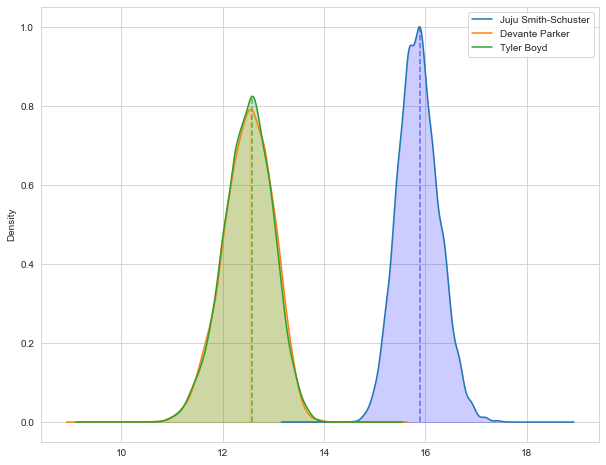

In [8]:
plot_kde(juju, parker, boyd, player_names=['Juju Smith-Schuster', 'Devante Parker', 'Tyler Boyd'])

In [7]:
def calculate_ceiling_floor(*arrays, player_names=None, stdout=False):

    data = {}

    for i, arr in enumerate(arrays):
      boot = calculate_bootstrap_df(arr).values

      mean = boot.mean() # find the mean of the means

      ceiling = np.percentile(boot, 95) # find the upper bound of the confidence interval
      floor = np.percentile(boot, 5) # find the lower bound of the confidence interval

      player_data = {
          'mean': mean,
          'ceiling': ceiling,
          'floor': floor
      }

      if player_names:
        data[player_names[i]] = player_data
      else:
        data[f'player_{i+1}'] = player_data

    if stdout:
      for player, player_data in data.items():
        print(player, 'has a mean projected output of', round(player_data['mean'], 2), \
              'a ceiling of', round(player_data['ceiling'], 2), 'and a floor of', round(player_data['floor'], 2))
        print('\n')

    return data

In [9]:
data = calculate_ceiling_floor(juju, parker, boyd, player_names=['Juju Smith-Schuster', 'Devante Parker', 'Tyler Boyd'], stdout=True)

Juju Smith-Schuster has a mean projected output of 15.86 a ceiling of 16.55 and a floor of 15.23


Devante Parker has a mean projected output of 12.48 a ceiling of 13.25 and a floor of 11.67


Tyler Boyd has a mean projected output of 12.49 a ceiling of 13.26 and a floor of 11.64


